# Browse Runs

Interactive notebook for monitoring training progress and visualizing runs.

**Usage:** Re-run this notebook to get the latest training status.

**CLI commands** (from `tdmpc2/` directory):
```bash
python -m discover status     # Quick status overview
python -m discover running    # Currently running tasks
python -m discover tasks      # All tasks with progress (225 official tasks)
python -m discover tasks --all  # Include non-official tasks (smoke-test, etc.)
python -m discover restart    # Show restart commands (add --submit to run)
python -m discover --help     # All available commands
```

## Setup

In [1]:
from pathlib import Path
import sys

# Ensure repo root is importable
ROOT = Path('..').resolve()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

# Change to ROOT for CLI commands
%cd {ROOT}

/home/projects/dharel/nadavt/repos/newt/tdmpc2


/home/projects/dharel/nadavt/.conda/envs/newt/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import numpy as np
import pandas as pd

# Notebook display defaults: don't truncate long outputs with `...`
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
np.set_printoptions(threshold=np.inf)

In [3]:
# Import the discover API
from discover import load_df, get_target_step
from discover.plots import training_overview, plot_max_steps, progress_by_domain

TARGET_STEP = get_target_step()
print(f"TARGET_STEP: {TARGET_STEP:,}")

TARGET_STEP: 5,000,000


## Load Runs Data

In [4]:
# load_df() loads merged runs from local logs + wandb (uses cache by default)
# Set refresh=True to force re-fetch from sources
df_all = load_df(refresh=True)
print(f"Loaded {len(df_all)} runs")

Scanning local logs (/home/projects/dharel/nadavt/repos/newt/tdmpc2/logs)...
  1599 local runs found        


Loaded 1599 runs


## Training Progress Overview

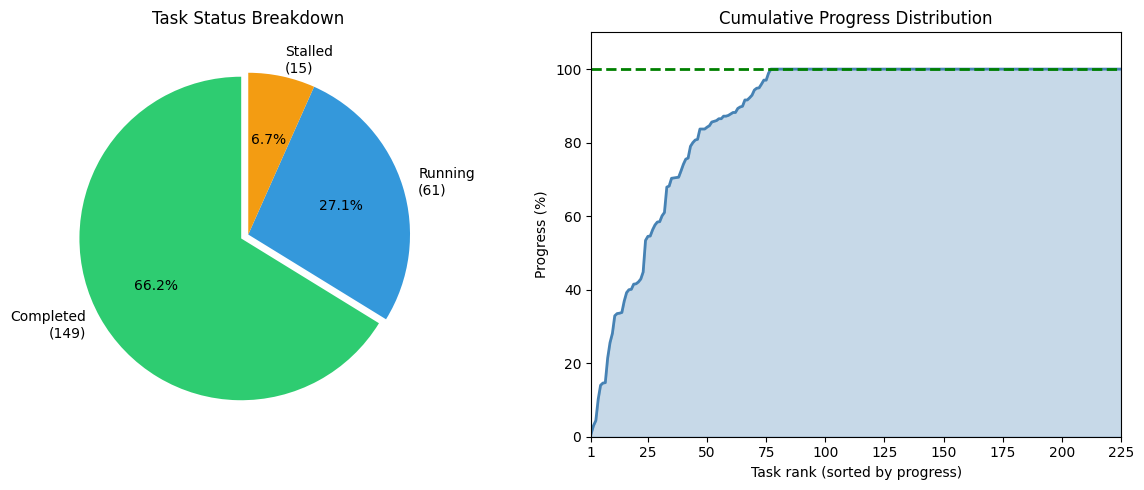

                 TRAINING PROGRESS SUMMARY                  
  Total tasks:            225  (from tasks.json)
  Target step:         5,000,000
------------------------------------------------------------
  🟢 ✅ Completed:         149 (66.2%)
  🔵 🏃 Running:            61 (27.1%)  <- active (see discover.liveness)
  🟠 ⏸️  Stalled:            15 (6.7%)  <- needs restart
  🔴 ❌ Not Started:         0 (0.0%)
------------------------------------------------------------
  Average progress:      87.9%
  Median progress:      100.0%
  Min steps:           39,006
  Max steps:           5,000,002


In [5]:
# training_overview: pie chart + summary stats
# Categories are computed via the central liveness + aggregation logic in `discover.liveness`.
training_overview(df_all, target_step=TARGET_STEP)

## Currently Running / Needs Restart (CLI)


In [6]:
# CLI: list all tasks with progress, running count, and status
# Options: --format json|csv, --not-started, --stalled, --running, --completed
!python -m discover tasks

                                        ALL TASKS                                         
Task                                            Progress     Max Step   HB   WB          Status
------------------------------------------------------------------------------------------
   ms-pick-cup                                     0.8%       39,006    0    0       🟠 stalled
   ms-pick-soccer-ball                             3.0%      147,898    0    0       🟠 stalled
   ms-pick-rubiks-cube                             4.4%      220,708    0    0       🟠 stalled
   ms-pick-golf-ball                              10.2%      510,798    1    0       🔵 running
   pygame-rocket-collect                          14.0%      700,636    0    0       🟠 stalled
   pygame-reacher-easy                            14.6%      730,812    0    0       🟠 stalled
   pygame-reacher-var1                            14.7%      736,732    0    0       🟠 stalled
   ms-push-screwdriver                            21.4%  

In [7]:
# CLI: progress aggregated by domain prefix (walker-*, mw-*, etc.)
!python -m discover domains

                               PROGRESS BY DOMAIN                               
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
acrobot                     1          1         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
cartpole                    6          6         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
cup                         2          2         100.0%         100.0%
finger                      3          3         100.0%         100.0%
fish                        1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
hopper                      3          3         100.0%         100.0%
jumper                      1          1         100.0%         100.0%
reacher                     4          4         100.0%  

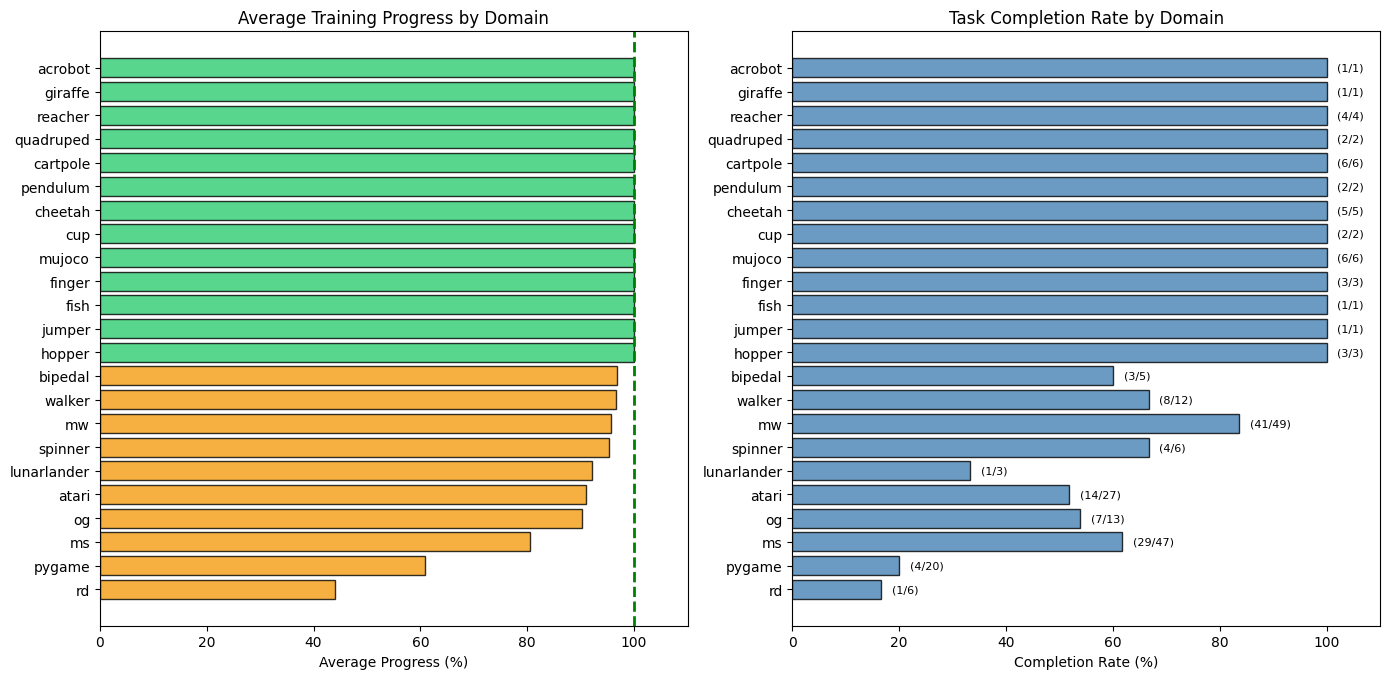


Domain Summary:
--------------------------------------------------------------------------------
Domain                  Tasks   Complete   Avg Progress   Completion %
--------------------------------------------------------------------------------
jumper                      1          1         100.0%         100.0%
fish                        1          1         100.0%         100.0%
giraffe                     1          1         100.0%         100.0%
reacher                     4          4         100.0%         100.0%
quadruped                   2          2         100.0%         100.0%
cartpole                    6          6         100.0%         100.0%
pendulum                    2          2         100.0%         100.0%
cheetah                     5          5         100.0%         100.0%
cup                         2          2         100.0%         100.0%
mujoco                      6          6         100.0%         100.0%
finger                      3          3

In [8]:
# progress_by_domain: visualization of domain-level progress
progress_by_domain(df_all, target_step=TARGET_STEP)

## 4. Currently Running


In [9]:
# CLI: shows tasks that are currently considered active by `discover.liveness`.
# (Any source-specific signals shown are derived from that central logic.)
!python -m discover running

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):             268
  Stale local 'running':       1180  ⚠️  (local-only)
  Tasks with running runs:       83
  Tasks needing restart:         15  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

🏃 CURRENTLY RUNNING TASKS (83 tasks):
   wandb running runs: 0 | alive heartbeats: 268
----------------------------------------------------------------------
Task                                      Wandb     HB     Progress     Max Step
----------------------------------------------------------------------
   ms-pick-golf-ball                          0      1       10.2%      510,798
   ms-push-screwdriver                        0      2       21.4%    1,069,742
   rd-flat-block-in-bin                       0      2       32.9%    1,644,710
   ms-push-sponge                             0      2       33.6%    1,679,3

## 5. Needs Restart

In [10]:
# CLI: shows bsub commands for tasks that need attention, according to `discover.liveness`.
# Add --submit to actually execute the bsub commands
!python -m discover restart

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):             263
  Stale local 'running':       1180  ⚠️  (local-only)
  Tasks with running runs:       83
  Tasks needing restart:         14  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

⚠️  TASKS NEEDING RESTART (14 tasks, no active signal; see discover.liveness):
----------------------------------------------------------------------
Task                                         Progress        Max Step     HB  Wandb
----------------------------------------------------------------------
   ms-pick-screwdriver                         87.4%       4,371,598      0      0
   ms-pick-spoon                               86.5%       4,327,498      0      0
   ms-pick-hammer                              85.6%       4,281,198      0      0
   pygame-cartpole-balance-sparse              41.6%       2,081,896     

In [11]:
# submitting all non-completed tasks (stalled or not started)
!python -m discover restart --submit

                         RUNNING RUNS SUMMARY                         
  Active runs (WB):               0
  Active runs (HB):             271
  Stale local 'running':       1180  ⚠️  (local-only)
  Tasks with running runs:       83
  Tasks needing restart:         15  ⚠️  (incomplete, no active signal)
  Tasks with stale runs:          0  🔄 (>1 wandb run, from resume)

⚠️  TASKS NEEDING RESTART (15 tasks, no active signal; see discover.liveness):
----------------------------------------------------------------------
Task                                         Progress        Max Step     HB  Wandb
----------------------------------------------------------------------
   ms-pick-screwdriver                         87.4%       4,371,598      0      0
   ms-pick-spoon                               86.5%       4,327,498      0      0
   ms-pick-hammer                              85.6%       4,281,198      0      0
   pygame-highway                              75.5%       3,774,846     

## 6. Eval Status

In [14]:
# # CLI: list tasks ready for eval (≥50% trained) and their video status
# # Use 'python -m discover eval submit --submit' to generate and submit eval jobs
# !python -m discover eval list --min-progress 0

In [15]:
# dry-run by default, add --submit to actually submit
!python -m discover eval submit --submit --min-progress 0

                    TASKS READY FOR EVALUATION (≥0% trained)                    

Total tasks at ≥0%: 225
  ✅ With videos:    142
  ❌ Without videos: 83

────────────────────────────────────────────────────────────────────────────────
Tasks WITH videos:
────────────────────────────────────────────────────────────────────────────────
  ✅ acrobot-swingup                                5,000,000 (100.0%)
  ✅ ms-place-sphere                                5,000,000 (100.0%)
  ✅ mw-coffee-push                                 5,000,000 (100.0%)
  ✅ mw-dial-turn                                   5,000,000 (100.0%)
  ✅ mw-disassemble                                 5,000,000 (100.0%)
  ✅ mw-door-close                                  5,000,000 (100.0%)
  ✅ mw-door-lock                                   5,000,000 (100.0%)
  ✅ mw-door-open                                   5,000,000 (100.0%)
  ✅ mw-drawer-open                                 5,000,000 (100.0%)
  ✅ mw-faucet-close                

## 7. Collect Videos

In [16]:
# CLI: collect videos from trained tasks into videos_for_presentation/
# Options: --min-progress 0.5, --copy (instead of symlinks), --output <dir>
# Then: rsync -avz server:tdmpc2/discover/videos_for_presentation/ ./videos/
!python -m discover videos collect --min-progress 0

                       VIDEOS COLLECTED FOR PRESENTATION                        

📁 Output directory: /home/projects/dharel/nadavt/repos/newt/tdmpc2/discover/videos_for_presentation
   Total videos: 142
   Method: symlinks
   🗑️  Pruned old videos: 25

────────────────────────────────────────────────────────────────────────────────
Task                                                  Step   Progress
────────────────────────────────────────────────────────────────────────────────
  acrobot-swingup                                5,000,000     100.0%
  atari-alien                                    4,700,000      94.0%
  atari-assault                                  4,800,000      96.0%
  atari-asterix                                  4,800,000      96.0%
  atari-atlantis                                 4,700,000      94.0%
  atari-bank-heist                               2,800,000      56.0%
  atari-gopher                                   4,100,000      82.0%
  atari-ice-hockey       